In [1]:
import time
import os

import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [3]:
from tensorflow.keras.metrics import Metric
class RSquare(Metric):
    """Compute R^2 score.
     This is also called as coefficient of determination.
     It tells how close are data to the fitted regression line.
     - Highest score can be 1.0 and it indicates that the predictors
       perfectly accounts for variation in the target.
     - Score 0.0 indicates that the predictors do not
       account for variation in the target.
     - It can also be negative if the model is worse.
     Usage:
     ```python
     actuals = tf.constant([1, 4, 3], dtype=tf.float32)
     preds = tf.constant([2, 4, 4], dtype=tf.float32)
     result = tf.keras.metrics.RSquare()
     result.update_state(actuals, preds)
     print('R^2 score is: ', r1.result().numpy()) # 0.57142866
    ```
    """

    def __init__(self, name='r_square', dtype=tf.float32):
        super(RSquare, self).__init__(name=name, dtype=dtype)
        self.squared_sum = self.add_weight("squared_sum", initializer="zeros")
        self.sum = self.add_weight("sum", initializer="zeros")
        self.res = self.add_weight("residual", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        self.squared_sum.assign_add(tf.reduce_sum(y_true**2))
        self.sum.assign_add(tf.reduce_sum(y_true))
        self.res.assign_add(
            tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred))))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        mean = self.sum / self.count
        total = self.squared_sum - 2 * self.sum * mean + self.count * mean**2
        return 1 - (self.res / total)

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.squared_sum.assign(0.0)
        self.sum.assign(0.0)
        self.res.assign(0.0)
        self.count.assign(0.0)

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

# Model training

## Hyperparameters

In [6]:
EX_PRED = 0
TRAINING_EPOCHS = 50
LIMIT = 3002
SHIELD = 5
BEST_PATH = "./models/best_LSTM.h5"

TIME_STEPS = 180
LEARNING_RATE = 0.001
EPSILON = 1e-04
N_HIDDEN = 256
BATCH_SIZE = 32
VAL_STEP = 500

## data loading

In [7]:
l = np.load('./env_set/dataset.npz')
train_input = l['train_input']
train_label = l['train_label']
test_input = l['test_input']
test_label = l['test_label']
MAXS = l['MAXS']
MINS = l['MINS']

TIME_STEPS = l['TIME_STEPS']
OUTPUT_SIZE = l['OUTPUT_SIZE']
NUM_FEATURES = train_input.shape[-1]

In [8]:
print(train_input.shape)
print(train_label.shape)

(41025, 24, 5)
(41025, 24, 5)


In [9]:
print(test_input.shape)
print(test_label.shape)

(16119, 24, 5)
(16119, 24, 5)


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*50).batch(BATCH_SIZE).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [11]:
with tf.device('/device:GPU:1'):
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(N_HIDDEN, input_shape=train_input.shape[-2:], return_sequences=True),
        tf.keras.layers.LayerNormalization(), # TEST
        tf.keras.layers.Dense(test_label.shape[-1])
    ])

In [12]:
lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON),
                   loss = tf.keras.losses.MeanSquaredError())
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 256)           268288    
_________________________________________________________________
layer_normalization (LayerNo (None, 24, 256)           512       
_________________________________________________________________
dense (Dense)                (None, 24, 5)             1285      
Total params: 270,085
Trainable params: 270,085
Non-trainable params: 0
_________________________________________________________________


In [13]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=BEST_PATH,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [14]:
lstm_model.fit(
    train_dataset, epochs = TRAINING_EPOCHS,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/50
139/144 [===========================>..] - ETA: 0s - loss: 0.0644
Epoch 00001: val_loss improved from inf to 0.01287, saving model to ./models/best_LSTM.h5
144/144 [==============================] - 6s 44ms/step - loss: 0.0625 - val_loss: 0.0129
Epoch 2/50
141/144 [============================>.] - ETA: 0s - loss: 0.0100
Epoch 00002: val_loss improved from 0.01287 to 0.01093, saving model to ./models/best_LSTM.h5
144/144 [==============================] - 2s 15ms/step - loss: 0.0099 - val_loss: 0.0109
Epoch 3/50
139/144 [===========================>..] - ETA: 0s - loss: 0.0090
Epoch 00003: val_loss did not improve from 0.01093
144/144 [==============================] - 2s 15ms/step - loss: 0.0091 - val_loss: 0.0144
Epoch 4/50
139/144 [===========================>..] - ETA: 0s - loss: 0.0062
Epoch 00004: val_loss improved from 0.01093 to 0.01033, saving model to ./models/best_LSTM.h5
144/144 [==============================] - 2s 15ms

In [15]:
test_loss = lstm_model.evaluate(test_dataset, steps=50)

print('Test Loss: {}'.format(test_loss))
#print('Test Accuracy: {}'.format(test_acc))

50/50 [==============================] - 0s 6ms/step - loss: 0.0095
Test Loss: 0.009466783506795765


In [16]:
pred_result = lstm_model.predict(test_dataset, steps=20)

# Model evaluation

In [17]:
trained_model = tf.keras.models.load_model(BEST_PATH)
trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 256)           268288    
_________________________________________________________________
layer_normalization (LayerNo (None, 24, 256)           512       
_________________________________________________________________
dense (Dense)                (None, 24, 5)             1285      
Total params: 270,085
Trainable params: 270,085
Non-trainable params: 0
_________________________________________________________________


In [18]:
np.set_printoptions(precision=6, suppress=True)

In [19]:
pred_result = trained_model.predict(test_dataset)

In [20]:
print(pred_result.shape)
print(test_label.shape)

(16119, 24, 5)
(16119, 24, 5)


In [21]:
for _ in range(test_label.shape[-1]):
    print(np.sqrt(mean_squared_error(test_label[:, :, _].reshape(-1), pred_result[:, :, _].reshape(-1))))

0.0683367524225678
0.05866105546077306
0.09482734843797436
0.05309619002081231
0.14849959415068845


In [22]:
r2 = RSquare()
for _ in range(test_label.shape[-1]):
    r2.reset_states()
    print(r2(tf.cast(test_label[:, :, _].reshape(-1), tf.float32), tf.cast(pred_result[:, :, _].reshape(-1), tf.float32)))

tf.Tensor(0.7577373, shape=(), dtype=float32)
tf.Tensor(0.8762705, shape=(), dtype=float32)
tf.Tensor(0.72949284, shape=(), dtype=float32)
tf.Tensor(0.46127534, shape=(), dtype=float32)
tf.Tensor(0.6490009, shape=(), dtype=float32)


[10, 40, 10, 40]

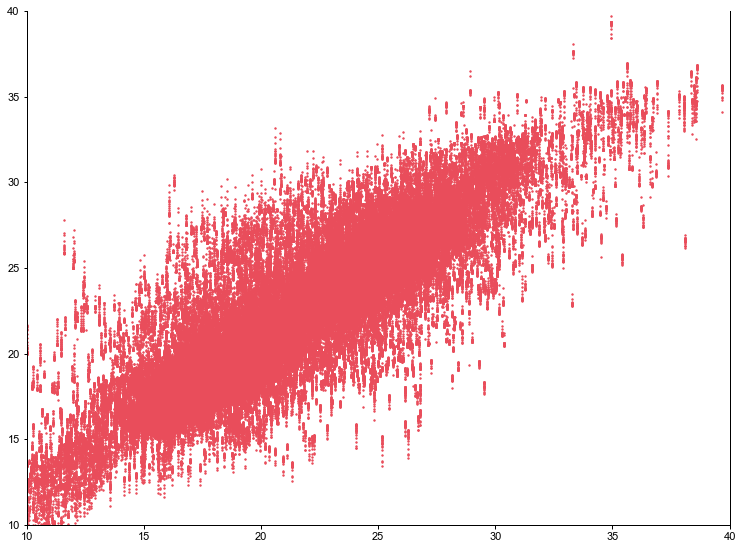

In [23]:
fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*4))
x = np.arange(0,2)
plt.plot(x, x, 'k')
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*pred_result + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[0], s=2
           )
plt.axis([10,40,10,40])
#plt.plot(x, tf.nn.softmax(logit[0][0, 5, :]).numpy(), c=cmap[0], alpha=0.2)
#plt.plot(x, tf.nn.softmax(logit[0][0, -1, :]).numpy(), c=cmap[3], alpha=0.2)

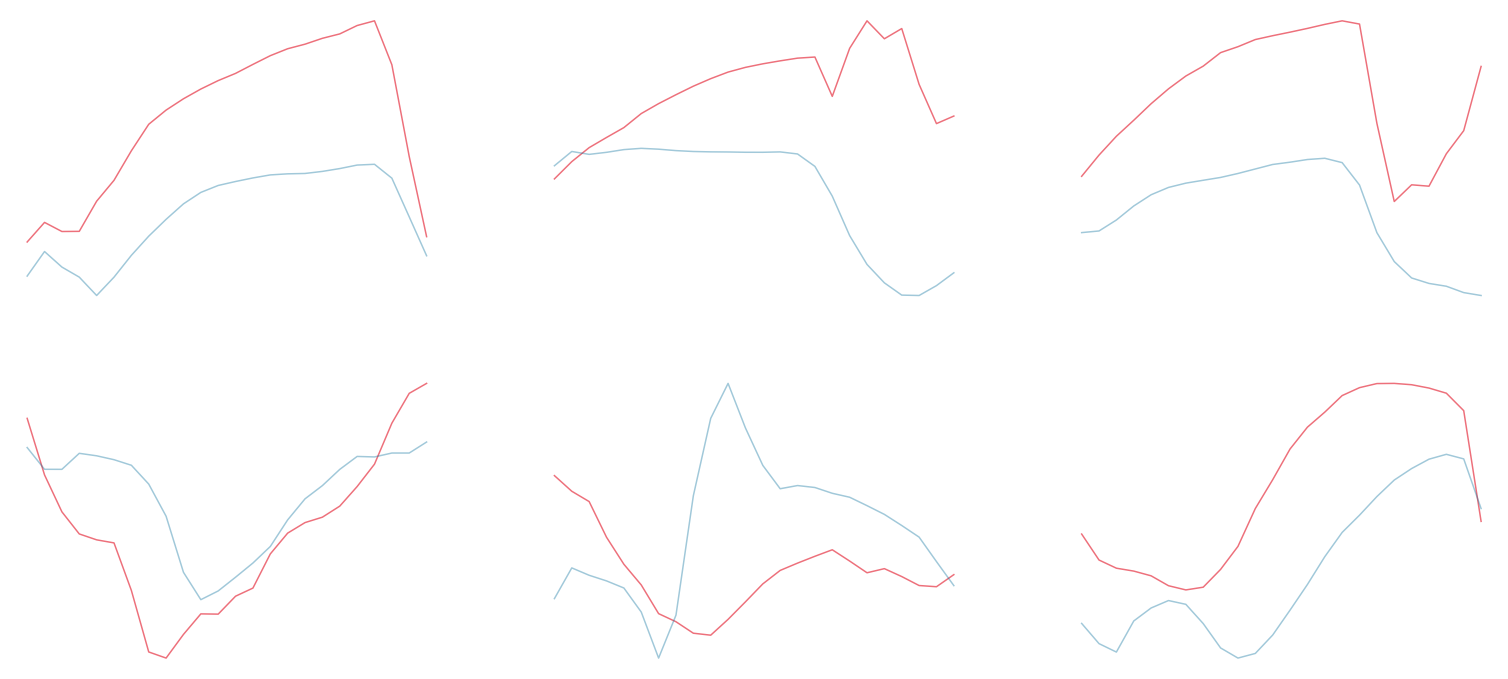

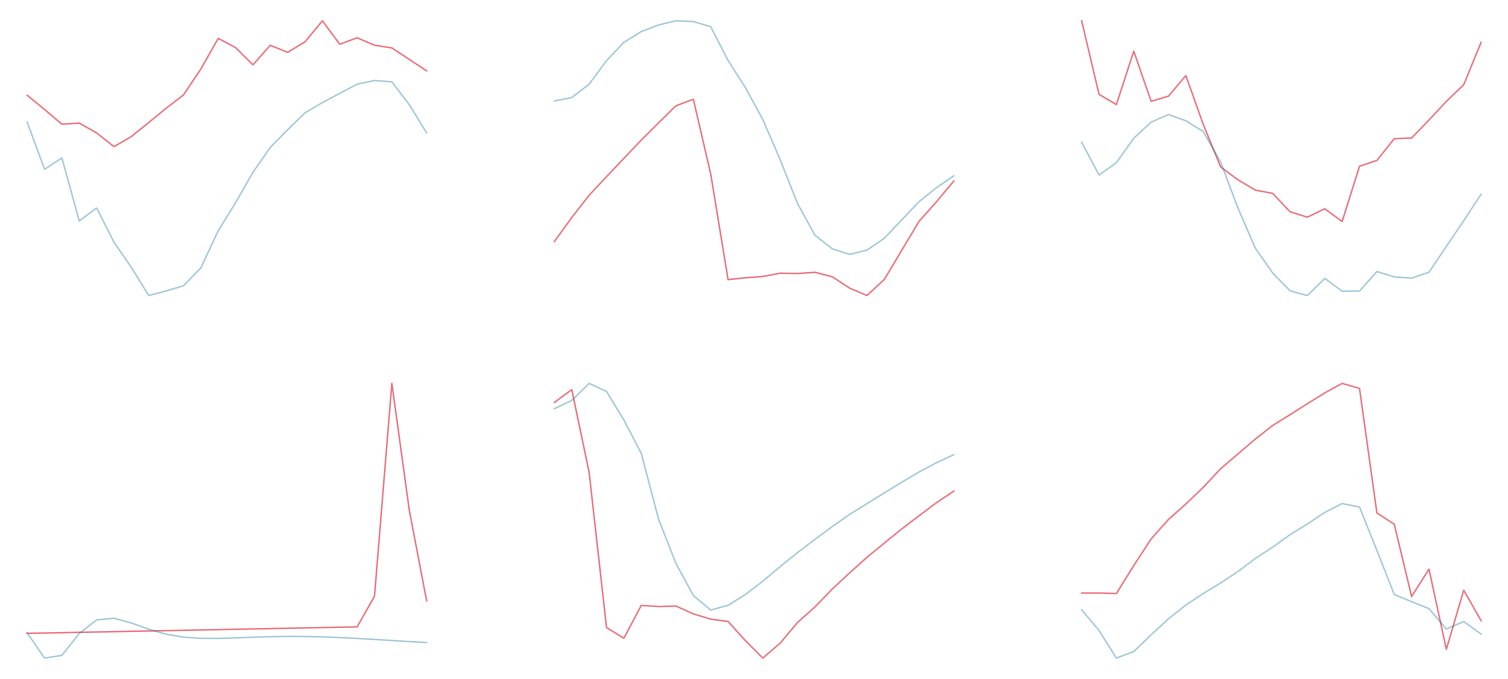

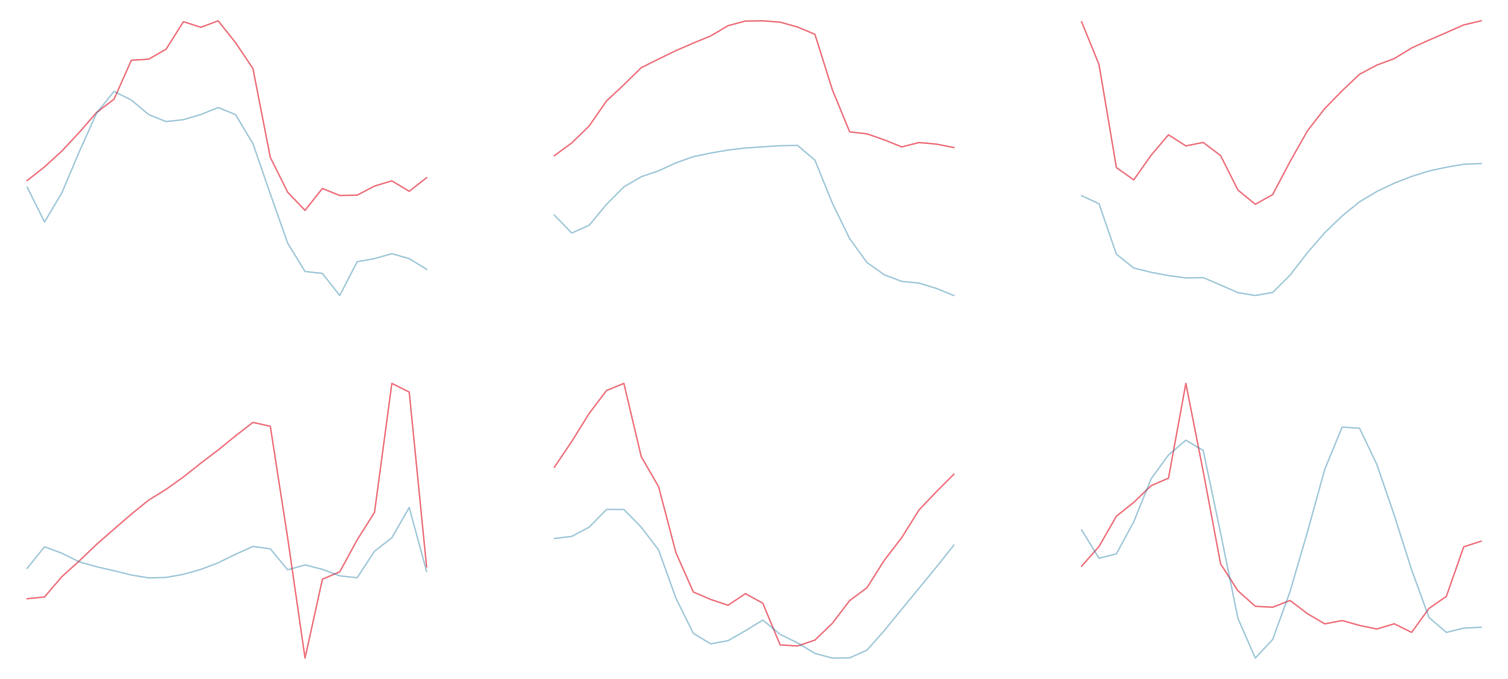

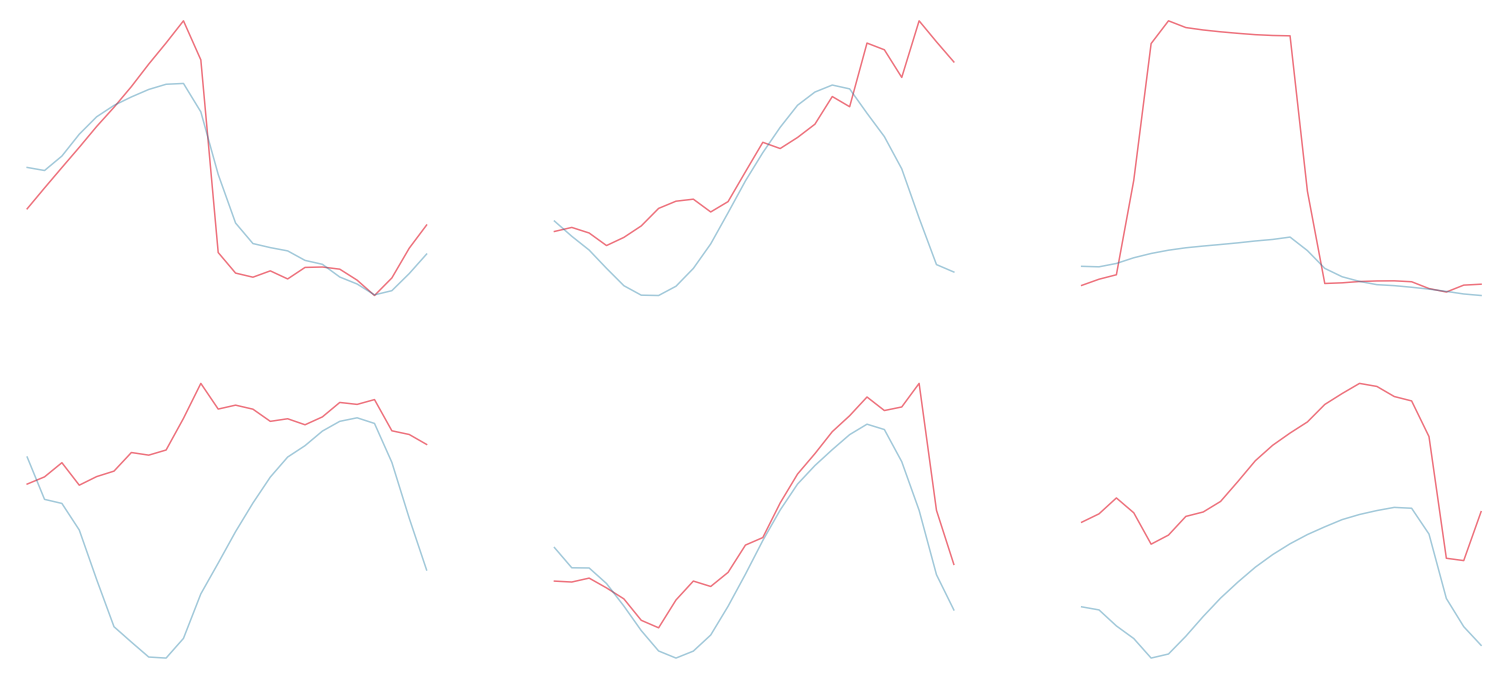

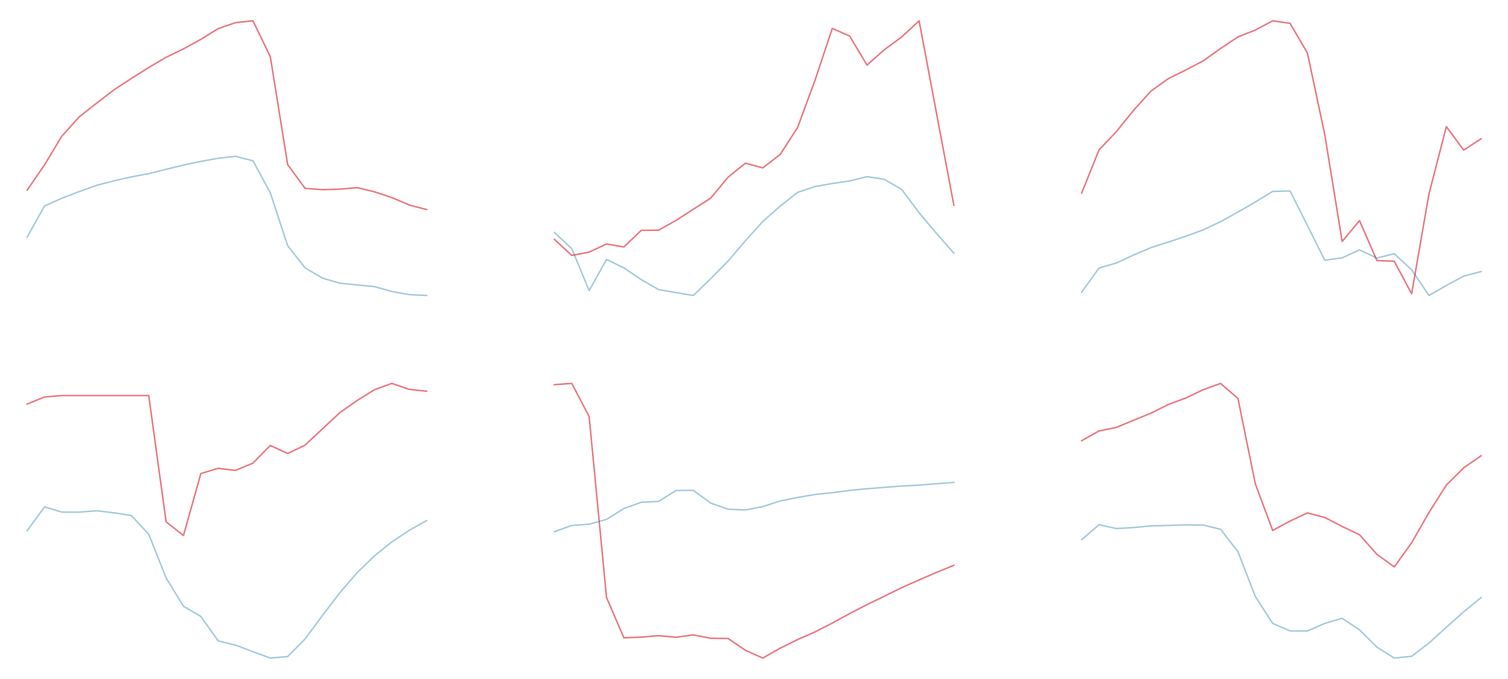

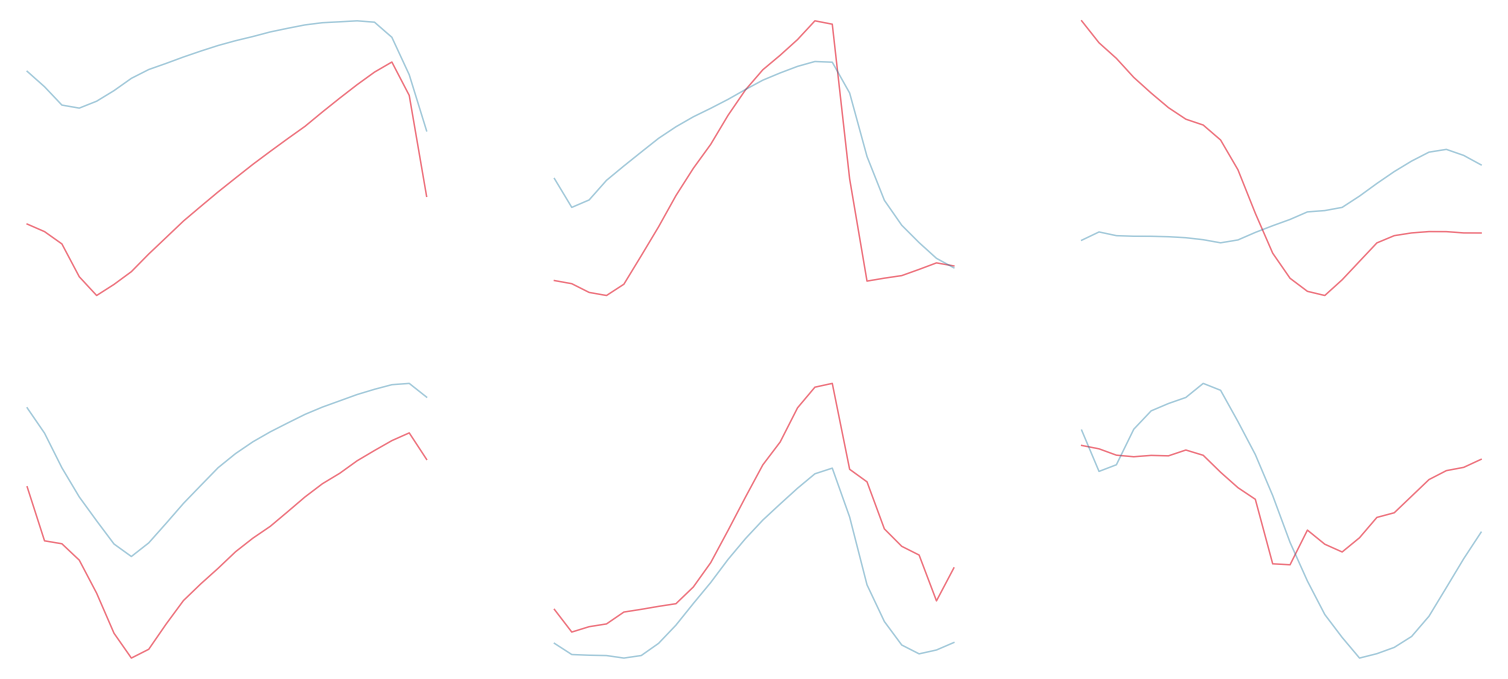

In [24]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (6):

        NUMBERS = np.arange(1, pred_result.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*8, (6/2.54)*8))
        
        i=3
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, test_label[NUMBER, :, i], c=cmap[0], alpha=0.8) #measured
            expect1 = plt.plot(x_t, pred_result[NUMBER, :, i], c=cmap[5], alpha=0.4) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1